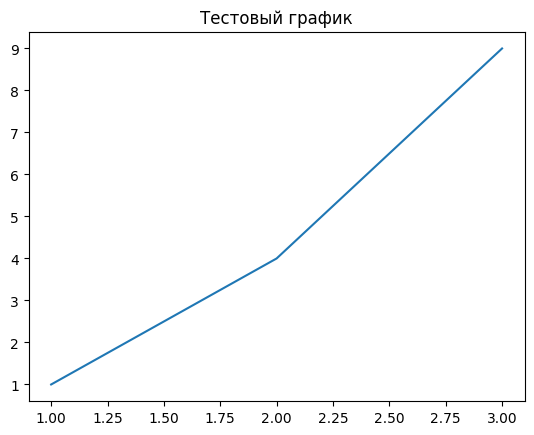

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([1, 2, 3], [1, 4, 9])
plt.title("Тестовый график")
plt.show()

Датасет

In [69]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.MNIST(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]


class CIFARDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.CIFAR10(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]


def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = MNISTDataset(train=True, transform=transform)
    test_dataset = MNISTDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


def get_cifar_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    train_dataset = CIFARDataset(train=True, transform=transform)
    test_dataset = CIFARDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader 

Сверточные модели

In [119]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class CNNWithResidual(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.res1 = ResidualBlock(32, 32)
        self.res2 = ResidualBlock(32, 64, 2)
        self.res3 = ResidualBlock(64, 64)
        
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(64 * 4 * 4, num_classes)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class CIFARCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x 

Полносвязная модель 

In [122]:
class FullyConnectedModel(nn.Module):
    def __init__(self, config_path=None, input_size=None, num_classes=None, **kwargs):
        super().__init__()
        
        if config_path:
            self.config = self.load_config(config_path)
        else:
            self.config = kwargs

        self.input_size = input_size or self.config.get('input_size', 784)
        self.num_classes = num_classes or self.config.get('num_classes', 10)

        self.layers = self._build_layers()

    def load_config(self, config_path):
        """
        Загружает конфигурацию из JSON файла
        """
        with open(config_path, 'r') as f:
            return json.load(f)

    def _build_layers(self):
        layers = []
        prev_size = self.input_size

        layer_config = self.config.get('layers', [])

        for layer_spec in layer_config:
            layer_type = layer_spec['type']

            match layer_type:
                case 'linear':
                    out_size = layer_spec['size']
                    layers.append(nn.Linear(prev_size, out_size))
                    prev_size = out_size

                case 'relu':
                    layers.append(nn.ReLU())

                case 'sigmoid':
                    layers.append(nn.Sigmoid())

                case 'tanh':
                    layers.append(nn.Tanh())

                case 'dropout':
                    rate = layer_spec.get('rate', 0.5)
                    layers.append(nn.Dropout(rate))

                case 'batch_norm':
                    layers.append(nn.BatchNorm1d(prev_size))

                case 'layer_norm':
                    layers.append(nn.LayerNorm(prev_size))

                case _:
                    raise ValueError(f"Неизвестный тип слоя: {layer_type}")

        # Всегда добавляем финальный слой для классификации
        layers.append(nn.Linear(prev_size, self.num_classes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # "выпрямляем" картинку в вектор
        return self.layers(x)

Конфигурации

In [78]:
config_3_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "batch_norm"},

        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "dropout", "rate": 0.4}
    ]
}
config_7_layer = {
    "input_size": 3072,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "linear", "size": 128},
        {"type": "relu"},
        {"type": "linear", "size": 64},
        {"type": "relu"},
        {"type": "linear", "size": 32},
        {"type": "relu"},
    ]
}


Обучение 

In [81]:
# Создаем функцию для grad flow 
def get_gradient_flow(model):
    avg_grads = []
    
    for name, param in model.named_parameters():
        if 'weight' in name and param.grad is not None:
            avg_grad = param.grad.abs().mean().item()#Считаем среднее значение градиента по модулю
            avg_grads.append((name, avg_grad))
    
    return avg_grads

In [96]:
def run_epoch(model, data_loader, criterion, optimizer=None, device='cpu', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()
    
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
        data, target = data.to(device), target.to(device)
        
        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        if not is_test and optimizer is not None:
            loss.backward()   
            optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    return total_loss / len(data_loader), correct / total


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)
        if epochs % 2 == 0:
            grads = get_gradient_flow(model)# вызов градиентов 
            for name, grad in grads:
                print(f"{name}: {grad:.6f}")
                
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    } 

Визуализация

In [86]:
def plot_training_history(history):
    """Визуализирует историю обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.legend()
    
    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


def count_parameters(model):
    """Подсчитывает количество параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def save_model(model, path):
    """Сохраняет модель"""
    torch.save(model.state_dict(), path)


def load_model(model, path):
    """Загружает модель"""
    model.load_state_dict(torch.load(path))
    return model


def compare_models(fc_history, cnn_history):
    """Сравнивает результаты полносвязной и сверточной сетей"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(fc_history['test_accs'], label='FC Network', marker='o')
    ax1.plot(cnn_history['test_accs'], label='CNN', marker='s')
    ax1.set_title('Test Accuracy Comparison')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(fc_history['test_losses'], label='FC Network', marker='o')
    ax2.plot(cnn_history['test_losses'], label='CNN', marker='s')
    ax2.set_title('Test Loss Comparison')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show() 

def compute_confusion_matrix(model, data_loader, device='cpu'):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Задание 1: Сравнение CNN и полносвязных сетей

In [16]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_loader, test_loader = get_mnist_loaders(batch_size=64)

simple_cnn = SimpleCNN(input_channels=1, num_classes=10).to(device)
residual_cnn = CNNWithResidual(input_channels=1, num_classes=10).to(device)
FCN_model = FullyConnectedModel(config_path=None, **config_3_layer)

print(f"Simple FCN parameters: {count_parameters(FCN_model)}")
print(f"Simple CNN parameters: {count_parameters(simple_cnn)}")
print(f"Residual CNN parameters: {count_parameters(residual_cnn)}")


Using device: cpu
Simple FCN parameters: 536842
Simple CNN parameters: 421642
Residual CNN parameters: 160906


Обучение каждой модели

# FCN

Training FCN model ...


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.91it/s]


Epoch 1/10:
Train Loss: 0.2192, Train Acc: 0.9366
Test Loss: 0.1070, Test Acc: 0.9662
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.16it/s]


Epoch 2/10:
Train Loss: 0.1151, Train Acc: 0.9653
Test Loss: 0.1042, Test Acc: 0.9715
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.81it/s]


Epoch 3/10:
Train Loss: 0.0906, Train Acc: 0.9716
Test Loss: 0.1216, Test Acc: 0.9725
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.58it/s]


Epoch 4/10:
Train Loss: 0.0734, Train Acc: 0.9765
Test Loss: 0.1262, Test Acc: 0.9766
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.84it/s]


Epoch 5/10:
Train Loss: 0.0693, Train Acc: 0.9775
Test Loss: 0.2055, Test Acc: 0.9734
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.96it/s]


Epoch 6/10:
Train Loss: 0.0558, Train Acc: 0.9824
Test Loss: 0.0896, Test Acc: 0.9773
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.82it/s]


Epoch 7/10:
Train Loss: 0.0491, Train Acc: 0.9841
Test Loss: 0.0819, Test Acc: 0.9796
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.42it/s]


Epoch 8/10:
Train Loss: 0.0445, Train Acc: 0.9858
Test Loss: 0.1365, Test Acc: 0.9782
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.33it/s]


Epoch 9/10:
Train Loss: 0.0432, Train Acc: 0.9858
Test Loss: 0.1756, Test Acc: 0.9792
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.92it/s]


Epoch 10/10:
Train Loss: 0.0373, Train Acc: 0.9873
Test Loss: 0.1341, Test Acc: 0.9811
--------------------------------------------------
Время вывполнения :434.8903396129608


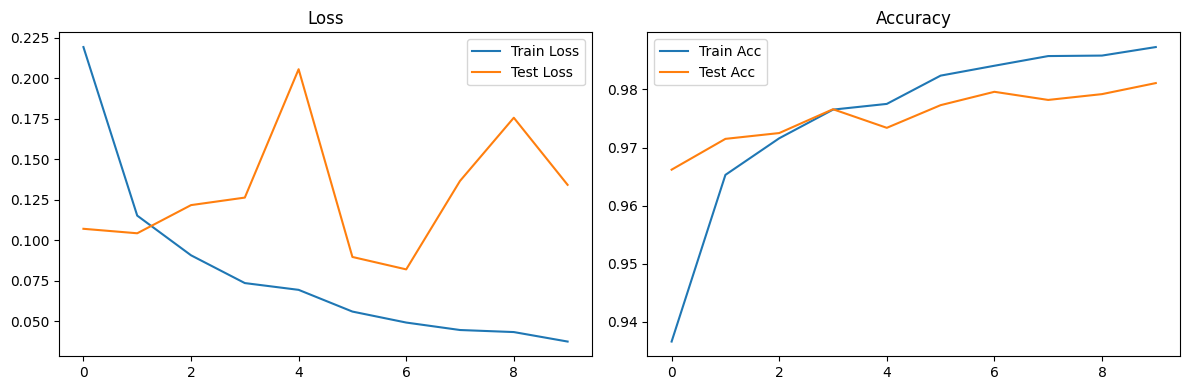

In [19]:
print("Training FCN model ...")
start_t = time.time()
FCN_history = train_model(FCN_model, train_loader, test_loader, epochs=10, device=str(device))
print(f'Время вывполнения :{time.time()-start_t}')

plot_training_history(FCN_history)

# SimpleCNN

Training Simple CNN...


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.56it/s]


Epoch 1/10:
Train Loss: 0.1586, Train Acc: 0.9510
Test Loss: 0.0457, Test Acc: 0.9840
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.98it/s]


Epoch 2/10:
Train Loss: 0.0555, Train Acc: 0.9829
Test Loss: 0.0301, Test Acc: 0.9897
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.70it/s]


Epoch 3/10:
Train Loss: 0.0408, Train Acc: 0.9874
Test Loss: 0.0303, Test Acc: 0.9897
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 17.21it/s]


Epoch 4/10:
Train Loss: 0.0296, Train Acc: 0.9907
Test Loss: 0.0235, Test Acc: 0.9920
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 16.31it/s]


Epoch 5/10:
Train Loss: 0.0241, Train Acc: 0.9926
Test Loss: 0.0236, Test Acc: 0.9923
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.70it/s]


Epoch 6/10:
Train Loss: 0.0204, Train Acc: 0.9937
Test Loss: 0.0314, Test Acc: 0.9903
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.74it/s]


Epoch 7/10:
Train Loss: 0.0183, Train Acc: 0.9940
Test Loss: 0.0273, Test Acc: 0.9920
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 16.93it/s]


Epoch 8/10:
Train Loss: 0.0157, Train Acc: 0.9950
Test Loss: 0.0265, Test Acc: 0.9932
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 16.30it/s]


Epoch 9/10:
Train Loss: 0.0123, Train Acc: 0.9959
Test Loss: 0.0271, Test Acc: 0.9922
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 16.51it/s]


Epoch 10/10:
Train Loss: 0.0126, Train Acc: 0.9956
Test Loss: 0.0284, Test Acc: 0.9924
--------------------------------------------------
Время вывполнения :1056.8950898647308


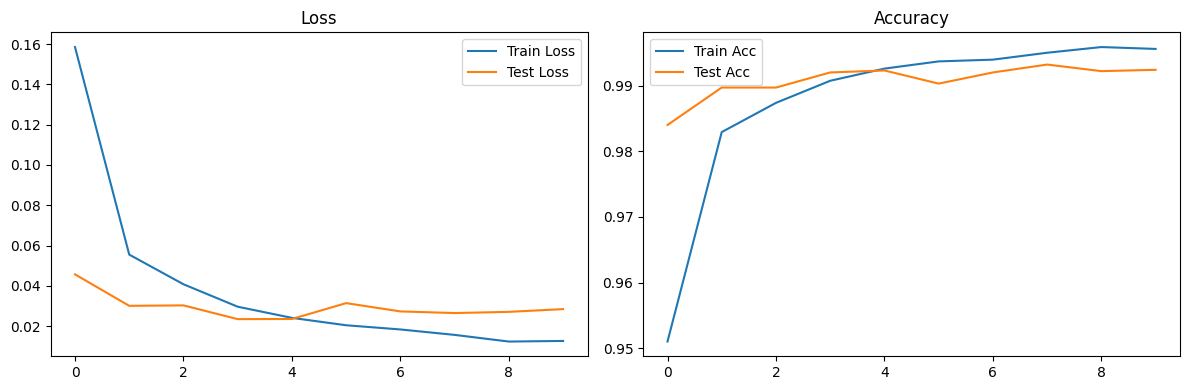

In [21]:
print("Training Simple CNN...")
start_t = time.time()
simple_history = train_model(simple_cnn, train_loader, test_loader, epochs=10, device=str(device))
print(f'Время вывполнения :{time.time()-start_t}')
plot_training_history(simple_history)

# ResidualCNN

Training Residual CNN...


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.68it/s]


Epoch 1/10:
Train Loss: 0.0986, Train Acc: 0.9708
Test Loss: 0.0445, Test Acc: 0.9854
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  7.10it/s]


Epoch 2/10:
Train Loss: 0.0377, Train Acc: 0.9878
Test Loss: 0.0263, Test Acc: 0.9913
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.50it/s]


Epoch 3/10:
Train Loss: 0.0307, Train Acc: 0.9904
Test Loss: 0.0258, Test Acc: 0.9919
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.86it/s]


Epoch 4/10:
Train Loss: 0.0254, Train Acc: 0.9921
Test Loss: 0.0186, Test Acc: 0.9936
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.65it/s]


Epoch 5/10:
Train Loss: 0.0223, Train Acc: 0.9931
Test Loss: 0.0357, Test Acc: 0.9893
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.96it/s]


Epoch 6/10:
Train Loss: 0.0189, Train Acc: 0.9938
Test Loss: 0.0215, Test Acc: 0.9934
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  7.11it/s]


Epoch 7/10:
Train Loss: 0.0166, Train Acc: 0.9947
Test Loss: 0.0266, Test Acc: 0.9911
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.67it/s]


Epoch 8/10:
Train Loss: 0.0147, Train Acc: 0.9952
Test Loss: 0.0209, Test Acc: 0.9928
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.76it/s]


Epoch 9/10:
Train Loss: 0.0137, Train Acc: 0.9955
Test Loss: 0.0170, Test Acc: 0.9944
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.67it/s]


Epoch 10/10:
Train Loss: 0.0117, Train Acc: 0.9963
Test Loss: 0.0327, Test Acc: 0.9893
--------------------------------------------------
Время вывполнения :4043.634134054184


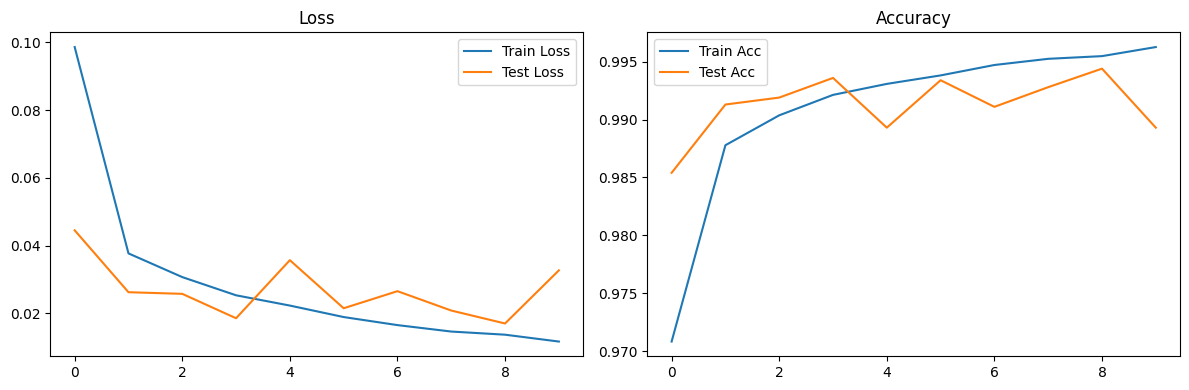

In [23]:
print("Training Residual CNN...")
start_t = time.time()
residual_history = train_model(residual_cnn, train_loader, test_loader, epochs=10, device=str(device))
print(f'Время вывполнения :{time.time()-start_t}')

plot_training_history(residual_history)

# compare_models(simple_history, residual_history) 

# Итог 1.1

## Полносвязная модель
Ситуация с loss неплохая, она скачет, больше всего ошибок совершено на 4-ой эпохе, однако все перекрывает то, что ошибки самые маленькие по эпохам среди рассмотренных моделей. С Accuracy на тоже хорошо обстоят дела. Параметр явно растет и нет сомнейний в том, что график будет расти и дальше. По времени этот способ классификации самый быстрый. 
## SimpleSNN
Из рассмотренных моделей - эта самая лучшая, показатели loss не скачут и к 10-ой эпохе ошибка все еще маленькая, конечно он начал полегоньку расти, но это нормально. Accuracy также очень радует, количество верных предсказаний к 10-ой эпохет продолжает расти, также отличным результатом является то, что тестовые значения очень несильно отличаются от тренировочных (Если посмотреть на ту же FCN, то разница явно больше, хоть и тоже не значительно). По времени она несильно больше чем FCN, время оправдывает результат
## ResidualCNN
Из рассмотренных данная модель самая худшая, показатель loss скачет и в итоге показывает в конце значительный прирост. Максимальная ошибка, как и в FCN, достигается на 4-ой эпохе, но она больше. Также плохо показывает себя и accuracy, график скачет и в тоге показывает спад. Гигантским минусом также является то, что эта модель намного дольше работает чем остальные, от самого быстрого она отстает в 10 раз. 

# 1.2 Сравнение на CIFAR-10

In [132]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_loader, test_loader = get_cifar_loaders(batch_size=64)

simple_cnn = SimpleCNN(input_channels=3, num_classes=10).to(device)
residual_cnn = CNNWithResidual(input_channels=3, num_classes=10).to(device)
FCN_model = FullyConnectedModel(config_path=None, **config_7_layer)

print(f"FCN parameters: {count_parameters(FCN_model)}")
print(f"Simple CNN parameters: {count_parameters(simple_cnn)}")
print(f"Residual CNN parameters: {count_parameters(residual_cnn)}")


Using device: cpu
FCN parameters: 1748266
Simple CNN parameters: 545098
Residual CNN parameters: 161482


# FCN

Training FCN model ...


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.83it/s]


layers.0.weight: 0.000322
layers.2.weight: 0.001919
layers.4.weight: 0.003579
layers.6.weight: 0.009821
layers.8.weight: 0.030750
layers.10.weight: 0.127884
Epoch 1/6:
Train Loss: 1.7192, Train Acc: 0.3854
Test Loss: 1.5636, Test Acc: 0.4508
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.86it/s]


layers.0.weight: 0.000239
layers.2.weight: 0.001177
layers.4.weight: 0.001646
layers.6.weight: 0.004645
layers.8.weight: 0.014998
layers.10.weight: 0.061591
Epoch 2/6:
Train Loss: 1.4918, Train Acc: 0.4721
Test Loss: 1.4653, Test Acc: 0.4829
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 19.91it/s]


layers.0.weight: 0.000282
layers.2.weight: 0.001382
layers.4.weight: 0.002354
layers.6.weight: 0.006917
layers.8.weight: 0.028010
layers.10.weight: 0.123020
Epoch 3/6:
Train Loss: 1.3711, Train Acc: 0.5189
Test Loss: 1.4418, Test Acc: 0.4959
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.35it/s]


layers.0.weight: 0.000210
layers.2.weight: 0.001126
layers.4.weight: 0.002065
layers.6.weight: 0.006196
layers.8.weight: 0.015804
layers.10.weight: 0.071060
Epoch 4/6:
Train Loss: 1.2799, Train Acc: 0.5494
Test Loss: 1.3759, Test Acc: 0.5163
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.08it/s]


layers.0.weight: 0.000209
layers.2.weight: 0.001175
layers.4.weight: 0.002131
layers.6.weight: 0.006205
layers.8.weight: 0.019991
layers.10.weight: 0.095053
Epoch 5/6:
Train Loss: 1.2010, Train Acc: 0.5760
Test Loss: 1.3607, Test Acc: 0.5252
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.49it/s]


layers.0.weight: 0.000450
layers.2.weight: 0.001742
layers.4.weight: 0.002576
layers.6.weight: 0.008171
layers.8.weight: 0.032936
layers.10.weight: 0.136024
Epoch 6/6:
Train Loss: 1.1225, Train Acc: 0.6015
Test Loss: 1.3612, Test Acc: 0.5268
--------------------------------------------------
Время вывполнения :288.38316321372986


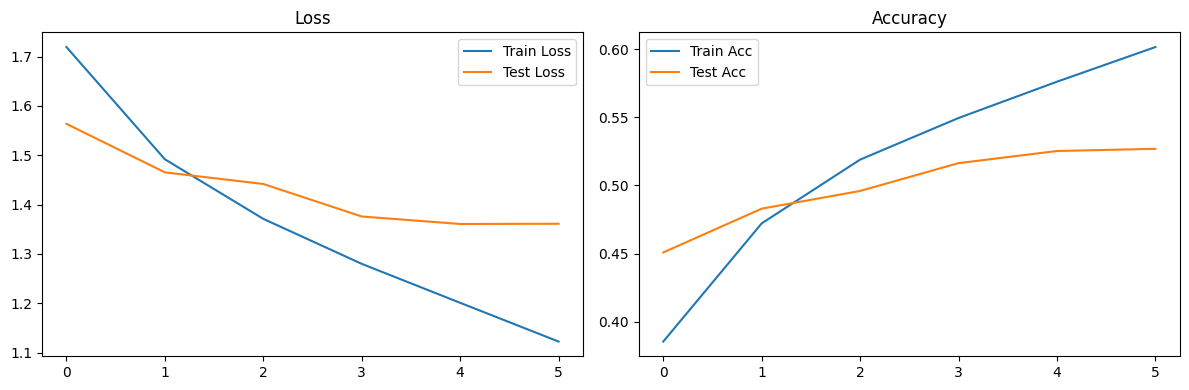

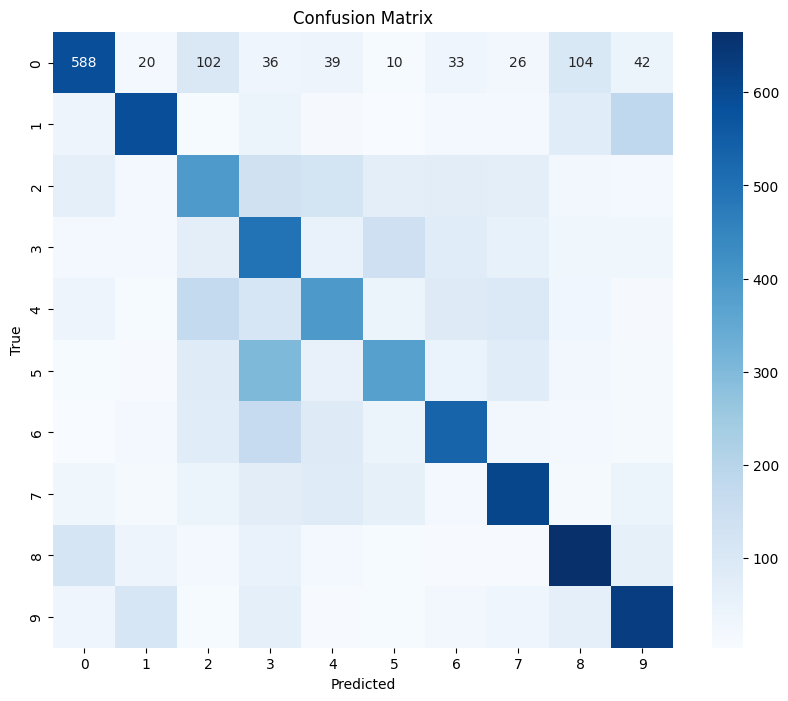

In [126]:
print("Training FCN model ...")
start_t = time.time()
FCN_history = train_model(FCN_model, train_loader, test_loader, epochs=6, device=str(device))
print(f'Время вывполнения :{time.time()-start_t}')

plot_training_history(FCN_history)
compute_confusion_matrix(FCN_model, test_loader, device=device)

# SimpleCNN

Training Simple CNN...


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 14.14it/s]


Epoch 1/5:
Train Loss: 1.3527, Train Acc: 0.5133
Test Loss: 1.0454, Test Acc: 0.6293
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:12<00:00, 12.37it/s]


Epoch 2/5:
Train Loss: 1.0072, Train Acc: 0.6446
Test Loss: 0.9430, Test Acc: 0.6720
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.17it/s]


Epoch 3/5:
Train Loss: 0.8770, Train Acc: 0.6912
Test Loss: 0.8753, Test Acc: 0.6931
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.38it/s]


Epoch 4/5:
Train Loss: 0.7727, Train Acc: 0.7277
Test Loss: 0.8361, Test Acc: 0.7057
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.38it/s]


Epoch 5/5:
Train Loss: 0.6893, Train Acc: 0.7568
Test Loss: 0.8714, Test Acc: 0.7082
--------------------------------------------------
Время вывполнения :524.3682317733765


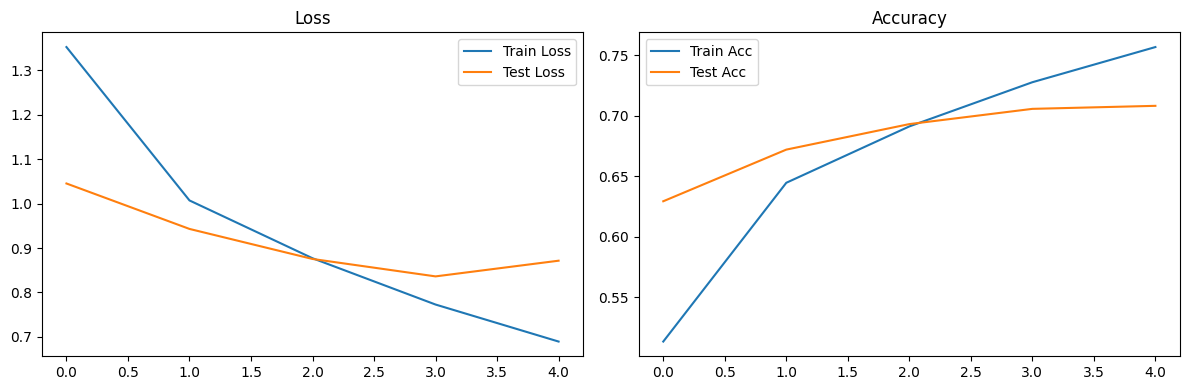

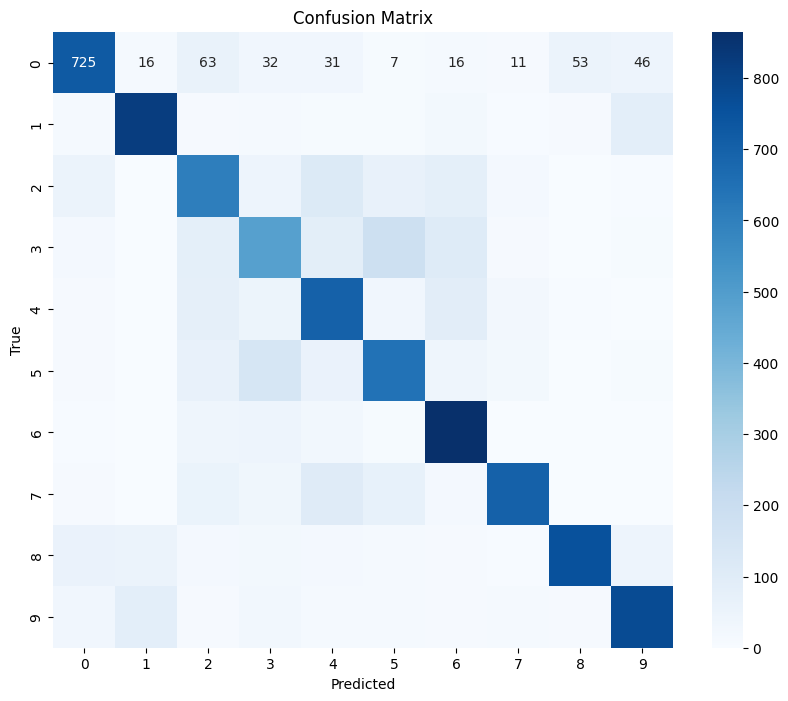

In [128]:
print("Training Simple CNN...")
start_t = time.time()
simple_history = train_model(simple_cnn, train_loader, test_loader, epochs=5, device=str(device))
print(f'Время вывполнения :{time.time()-start_t}')
plot_training_history(simple_history)
compute_confusion_matrix(simple_cnn, test_loader, device=device)

# ResidualCNN

Training Residual CNN...


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.42it/s]


conv1.weight: 0.094004
bn1.weight: 0.020204
res1.conv1.weight: 0.014310
res1.bn1.weight: 0.015378
res1.conv2.weight: 0.011714
res1.bn2.weight: 0.012628
res2.conv1.weight: 0.005989
res2.bn1.weight: 0.009625
res2.conv2.weight: 0.004220
res2.bn2.weight: 0.011662
res2.shortcut.0.weight: 0.011685
res2.shortcut.1.weight: 0.008113
res3.conv1.weight: 0.003580
res3.bn1.weight: 0.008737
res3.conv2.weight: 0.003474
res3.bn2.weight: 0.011536
fc.weight: 0.038067
Epoch 1/6:
Train Loss: 1.1726, Train Acc: 0.5815
Test Loss: 0.9316, Test Acc: 0.6686
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


conv1.weight: 0.069466
bn1.weight: 0.015898
res1.conv1.weight: 0.009344
res1.bn1.weight: 0.014304
res1.conv2.weight: 0.007999
res1.bn2.weight: 0.015423
res2.conv1.weight: 0.004523
res2.bn1.weight: 0.008879
res2.conv2.weight: 0.003106
res2.bn2.weight: 0.010466
res2.shortcut.0.weight: 0.010124
res2.shortcut.1.weight: 0.007463
res3.conv1.weight: 0.002940
res3.bn1.weight: 0.011444
res3.conv2.weight: 0.002828
res3.bn2.weight: 0.010277
fc.weight: 0.021484
Epoch 2/6:
Train Loss: 0.7851, Train Acc: 0.7268
Test Loss: 0.8112, Test Acc: 0.7134
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.90it/s]


conv1.weight: 0.109847
bn1.weight: 0.023137
res1.conv1.weight: 0.013681
res1.bn1.weight: 0.020222
res1.conv2.weight: 0.011575
res1.bn2.weight: 0.019018
res2.conv1.weight: 0.006620
res2.bn1.weight: 0.012760
res2.conv2.weight: 0.005210
res2.bn2.weight: 0.024261
res2.shortcut.0.weight: 0.017342
res2.shortcut.1.weight: 0.015334
res3.conv1.weight: 0.005249
res3.bn1.weight: 0.021795
res3.conv2.weight: 0.004418
res3.bn2.weight: 0.018852
fc.weight: 0.040026
Epoch 3/6:
Train Loss: 0.6531, Train Acc: 0.7733
Test Loss: 0.6983, Test Acc: 0.7639
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.86it/s]


conv1.weight: 0.127382
bn1.weight: 0.025480
res1.conv1.weight: 0.012210
res1.bn1.weight: 0.019946
res1.conv2.weight: 0.010476
res1.bn2.weight: 0.024268
res2.conv1.weight: 0.006662
res2.bn1.weight: 0.014187
res2.conv2.weight: 0.005245
res2.bn2.weight: 0.017378
res2.shortcut.0.weight: 0.016452
res2.shortcut.1.weight: 0.016195
res3.conv1.weight: 0.004838
res3.bn1.weight: 0.021045
res3.conv2.weight: 0.003996
res3.bn2.weight: 0.016312
fc.weight: 0.027786
Epoch 4/6:
Train Loss: 0.5689, Train Acc: 0.8031
Test Loss: 0.6557, Test Acc: 0.7762
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.82it/s]


conv1.weight: 0.078766
bn1.weight: 0.019403
res1.conv1.weight: 0.006233
res1.bn1.weight: 0.012559
res1.conv2.weight: 0.006262
res1.bn2.weight: 0.010673
res2.conv1.weight: 0.003935
res2.bn1.weight: 0.010812
res2.conv2.weight: 0.003223
res2.bn2.weight: 0.016804
res2.shortcut.0.weight: 0.011272
res2.shortcut.1.weight: 0.013986
res3.conv1.weight: 0.003073
res3.bn1.weight: 0.016769
res3.conv2.weight: 0.002562
res3.bn2.weight: 0.015309
fc.weight: 0.015805
Epoch 5/6:
Train Loss: 0.4964, Train Acc: 0.8285
Test Loss: 0.6290, Test Acc: 0.7829
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.73it/s]


conv1.weight: 0.126789
bn1.weight: 0.036607
res1.conv1.weight: 0.012986
res1.bn1.weight: 0.022266
res1.conv2.weight: 0.011896
res1.bn2.weight: 0.023756
res2.conv1.weight: 0.007543
res2.bn1.weight: 0.021961
res2.conv2.weight: 0.006176
res2.bn2.weight: 0.030840
res2.shortcut.0.weight: 0.020843
res2.shortcut.1.weight: 0.023276
res3.conv1.weight: 0.006003
res3.bn1.weight: 0.027569
res3.conv2.weight: 0.004418
res3.bn2.weight: 0.022143
fc.weight: 0.029847
Epoch 6/6:
Train Loss: 0.4433, Train Acc: 0.8466
Test Loss: 0.6627, Test Acc: 0.7754
--------------------------------------------------
Время вывполнения :2428.860034227371


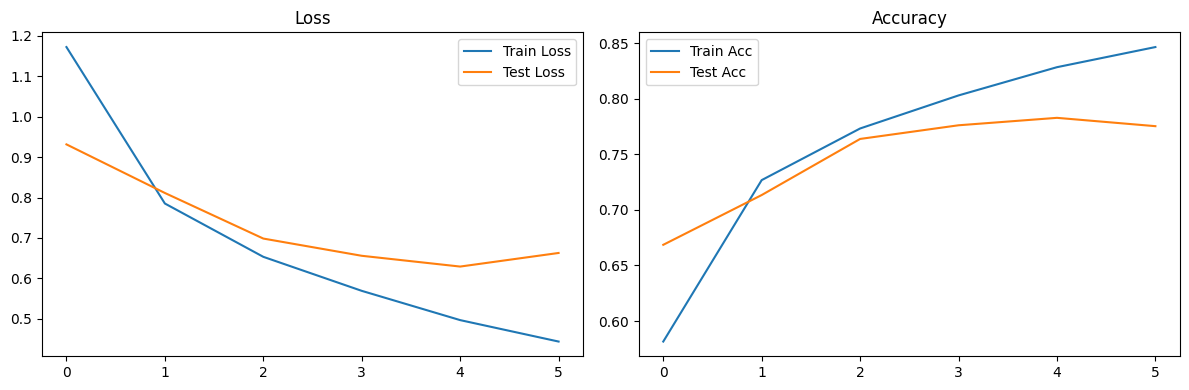

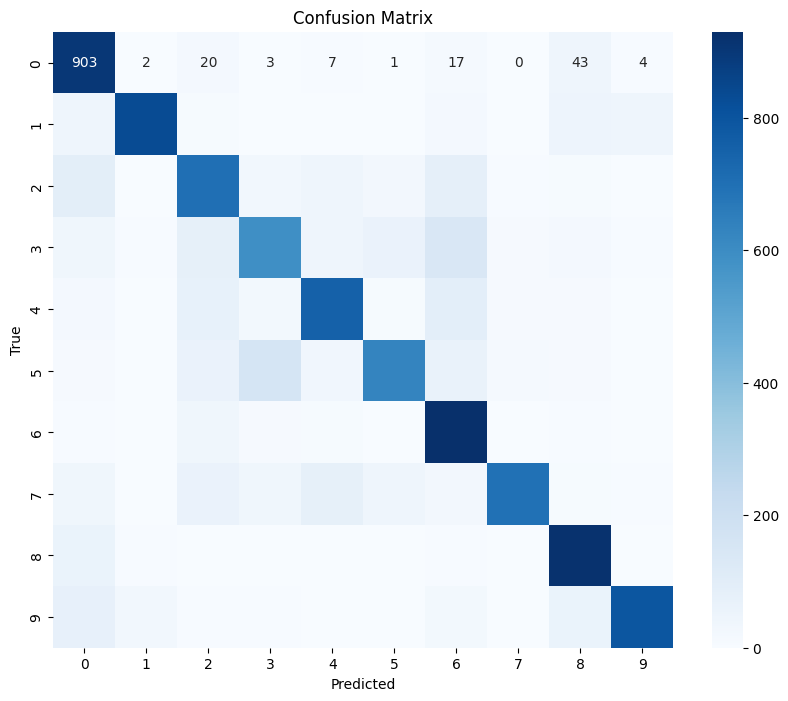

In [134]:
print("Training Residual CNN...")
start_t = time.time()
residual_history = train_model(residual_cnn, train_loader, test_loader, epochs=6, device=str(device))
print(f'Время вывполнения :{time.time()-start_t}')

plot_training_history(residual_history)
compute_confusion_matrix(residual_cnn, test_loader, device=device)

# Итог 1.2

## Полносвязная модель
Ситуация с loss похуже чем с MNIST, график почти не совпадает с тренировачными и он растет. C Accuracy хуже начал предсказывать и начал мне кажется потехоньку падать. Данная модель все также быстрее всех. 
## SimpleSNN
Результат получше чем у полносвязной модели, но все равно не очень хорошо. Плюс в том, что от полносвязной, данная модель получше подгоняется под результаты тренировачные 
## ResidualCNN
Данная модель лучше полносвязной, но хуже простойCNN. Данная модель сначала неплохо предсказывала значения и ошибка была такой же как у тернировочных, но потом результаты становились заметно хуже. По времени данная модель также самая медленная 

Смотря по градиетам моделей, можно сделать вывод, что модели чаще всего ошибаются в классе 3 (чаще всего путают с классом 5). Ну а так более менее стабильно отгадывают те классы, которые от них ожидались.

По весам можно увидеть, что у моделей низкие и высокие веса постоянно более заметно меняют значения. Это говорит о том, что модель изменяет веса и меняет те, которые почти не повлияли на обучение, либо сильно влияют. 